Importing libraries to use for preprocessing (turning text features into numerical ones), building the naive bayes classifier, and evaluating the model.

In [1]:
# Import libraries
import pandas as pd
from nltk.stem import WordNetLemmatizer
from nltk import word_tokenize
import nltk
#nltk.download('wordnet')
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score, cross_val_predict, train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn import metrics
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay

Initializing the following objects:

* lemmatizer - to perform lemmatization
  
* count_vectorizer - to turn text features into numerical word counts

* tfidf_transformer - to turn numerical word counts into tfidf scores

* nb_clf - to build the naive bayes classifier

In [2]:
# Initialization
lemmatizer = WordNetLemmatizer()
count_vectorizer = CountVectorizer(stop_words="english", min_df=0.015)
tfidf_transformer = TfidfTransformer()
nb_clf = MultinomialNB()

Read in hand labeled data (235 total instances)

* filter for instances with a single label (232 instances)

* keep descriptions, and hand labels

* Show the number of instances for each label

In [3]:
# Read in hand labeled data 
filepath = "df_ver_combined_hand-labels.csv"
df = pd.read_csv(filepath, nrows=235) # reads in hand labeled data
df = df[((df['hand_label']=="['media']") | (df['hand_label']=="['academia']") | (df['hand_label']=="['government']") | (df['hand_label']=="['other']"))] # use single labels
df = df[['username','description','hand_label']] # keep only relevant columns
print(df.head())
print()
print('Number of labels per category:')
print(df['hand_label'].value_counts())
print()

          username                                        description  \
0      annenbcnews  Chief Environmental Affairs Correspondent, NBC...   
1            USFSM  The official Twitter account for the Universit...   
2   KMillerWeather  Real estate and growth reporter for The Palm B...   
4  WhySharksMatter  Research associate at @ASU @ASUinDC studying s...   
5      Casper30214  Army Civil Service(Retired);Military Ops Resea...   

     hand_label  
0     ['media']  
1  ['academia']  
2     ['media']  
4  ['academia']  
5     ['other']  

Number of labels per category:
['media']         166
['government']     32
['other']          26
['academia']        8
Name: hand_label, dtype: int64



Preprocessing

* lowercase and tokenize to perform lemmatization

* transform description into lemmatized list of tokens - description_lemmatized

* description_lemmatized will be used as input into count_vectorizer

In [4]:
# Preprocessing step - lemmatization on description column
words_not_changed = ['media']
def preprocessing(row):
    row = row.lower()                                                                               # lowercase (so that upper and lowercase words are treated the same)
    row = word_tokenize(row)                                                                        # tokenize  (to perform lemmitization)                                                         
    row = [lemmatizer.lemmatize(word) if word not in words_not_changed else word for word in row]   # lemmatize  
    return str(row)                                                                                 # convert back to string    
df['description_lemmatized'] = df['description'].apply(preprocessing)                               # apply preprocessing function to description column
print(df.head())
print()

          username                                        description  \
0      annenbcnews  Chief Environmental Affairs Correspondent, NBC...   
1            USFSM  The official Twitter account for the Universit...   
2   KMillerWeather  Real estate and growth reporter for The Palm B...   
4  WhySharksMatter  Research associate at @ASU @ASUinDC studying s...   
5      Casper30214  Army Civil Service(Retired);Military Ops Resea...   

     hand_label                             description_lemmatized  
0     ['media']  ['chief', 'environmental', 'affair', 'correspo...  
1  ['academia']  ['the', 'official', 'twitter', 'account', 'for...  
2     ['media']  ['real', 'estate', 'and', 'growth', 'reporter'...  
4  ['academia']  ['research', 'associate', 'at', '@', 'asu', '@...  
5     ['other']  ['army', 'civil', 'service', '(', 'retired', '...  



Split data into training and test sets (stratified to preserve label distribution) - otherwise media could dominate the sets due to imbalance

* X = feature, description_lemmatized

* y = target, hand_label

* value counts in the train set and test set

In [12]:
# Split data into train and test sets (stratified so that each class is represented proportionately in train and test sets)
X = df['description_lemmatized']
y = df['hand_label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y) # stratify to keep a representative proportion of each class

In [13]:
print(X_train.shape)

(185,)


In [14]:
print(y_train)

55          ['other']
181         ['media']
64          ['media']
60          ['other']
168         ['media']
            ...      
229         ['media']
90          ['media']
160         ['media']
32     ['government']
194         ['media']
Name: hand_label, Length: 185, dtype: object


In [15]:
print(y_train.value_counts())

['media']         132
['government']     26
['other']          21
['academia']        6
Name: hand_label, dtype: int64


In [16]:
print(y_test.value_counts())

['media']         34
['government']     6
['other']          5
['academia']       2
Name: hand_label, dtype: int64


Pipeline Creation

* create separate pipelines for word frequencies and tfidf score features
  
* Define parameters for grid search to identify the best hyperparameters in each model based on accuracy metric

* grid search explores different combinations of hyperparameters and select best values based on the scoring metric using 5 fold cross validation

In [17]:
# Pipeline Creation for Naive Bayes word frequencies and tfidf weighting
nb_count_pipeline = Pipeline([('vectorizer', count_vectorizer),
                              ('classifier', nb_clf)])

param_count_grid = [
    {'vectorizer__min_df': [0, 0.01, 0.03, 0.05, 0.10, 0.15, 0.20],
     'classifier__alpha': [1.0e-10, 0.5, 2.0, 5.0, 10.0],
     'classifier__fit_prior': [True, False]}
]

grid_search_count = GridSearchCV(nb_count_pipeline, param_count_grid, cv=5, scoring='accuracy', verbose=1)

nb_tfidf_pipeline = Pipeline([('vectorizer', count_vectorizer),
                              ('transformer', tfidf_transformer),           
                              ('classifier', nb_clf)])

param_tfidf_grid = [
    {'vectorizer__min_df': [0, 0.01, 0.03, 0.05, 0.10, 0.15, 0.20],
        'transformer__use_idf': [True, False],
        'classifier__alpha': [1.0e-10, 0.5, 2.0, 5.0, 10.0],
        'classifier__fit_prior': [True, False]}
]

grid_search_tfidf = GridSearchCV(nb_tfidf_pipeline, param_tfidf_grid, cv=5, scoring='accuracy', verbose=1)

Best hyperparamters

* fit grid search objects on train set to identify the best hyperparameters based on accuracy metric

In [18]:
# Best hyperparameters for Naive Bayes word frequencies and tfidf weighting
grid_search_count.fit(X_train, y_train)
grid_search_tfidf.fit(X_train, y_train)

print('NB word frequencies - cross validation accuracy:')
print(grid_search_count.best_score_)
print()

print('NB word frequencies - best parameters:')
print(grid_search_count.best_params_)
print()

print('NB tfidf - cross validation accuracy:')
print(grid_search_tfidf.best_score_)
print()

print('NB tfidf - best parameters:')
print(grid_search_tfidf.best_params_)
print()

Fitting 5 folds for each of 70 candidates, totalling 350 fits


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
50 fits failed out of a total of 350.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/p

Fitting 5 folds for each of 140 candidates, totalling 700 fits
NB word frequencies - cross validation accuracy:
0.7945945945945947

NB word frequencies - best parameters:
{'classifier__alpha': 0.5, 'classifier__fit_prior': True, 'vectorizer__min_df': 0.01}

NB tfidf - cross validation accuracy:
0.8

NB tfidf - best parameters:
{'classifier__alpha': 10.0, 'classifier__fit_prior': False, 'transformer__use_idf': True, 'vectorizer__min_df': 0.01}



/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
100 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 732, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py", line 1151, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "/Library/Frameworks/Python.framework/Versions/3.9/lib

### Prior output for grid search:

* Fitting 5 folds for each of 50 candidates, totalling 250 fits
* Fitting 5 folds for each of 100 candidates, totalling 500 fits
  
**NB word frequencies - cross validation accuracy:**

0.8054054054054054

**NB word frequencies - best parameters:**

{'classifier__alpha': 1.5, 'classifier__fit_prior': True, 'vectorizer__min_df': 0.01}

**NB tfidf - cross validation accuracy:**

0.8108108108108109

**NB tfidf - best parameters:**

{'classifier__alpha': 0.1, 'classifier__fit_prior': True, 'transformer__use_idf': True, 'vectorizer__min_df': 0.01}

### With parameters below:

param_count_grid = [

    {'vectorizer__min_df': [0.01, 0.015, 0.02, 0.025, 0.03],

     'classifier__alpha': [0.1, 0.5, 1.0, 1.5, 2.0],

     'classifier__fit_prior': [True, False]}
]

param_tfidf_grid = [

    {'vectorizer__min_df': [0.01, 0.015, 0.02, 0.025, 0.03],

        'transformer__use_idf': [True, False],

        'classifier__alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
        
        'classifier__fit_prior': [True, False]}
]

Cross Validation for best hyperparameters

* set the best hyperparameters and refit on train set

* apply cross validation on the models with the best hyperparameters to gauge performance

* macro vs micro

skleanr states that macro calculates metrics for each label and finds their unweighted mean.

micro counts total true positives, false negatives, and false positives giving equal weight to each instance.

One may be more "optimistic" in the reporting of scores than the other.

In [19]:
nb_count_pipeline.set_params(**grid_search_count.best_params_)
nb_tfidf_pipeline.set_params(**grid_search_tfidf.best_params_)
nb_count_pipeline.fit(X_train, y_train)
nb_tfidf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(min_df=0.01, stop_words='english')),
                ('transformer', TfidfTransformer()),
                ('classifier', MultinomialNB(alpha=10.0, fit_prior=False))])


Macro averaging - treats each class equally to evaluate the overall performance of a classifier

* ignores class imbalance 

* calculates metrics for each class and then takes the average

Micro averaging - treats individual instances equally to evaluate the overall performance of a classifier

* pulls in all isntances to calculate metrics

* doesn't count for imbalance

F1 score - harmonic mean of recall and precision

* measure of the models ability to capture positive cases and be accurate

* precision - accuracy in the positive predictions

* recall - ratio of positive instances that are correctly detected

Confusion Matrices for each model over the 5 folds on the train set

It aggregates the validation set over the 5 folds to produce the confusion matrix.

Confusion Matrix for NB word frequencies:


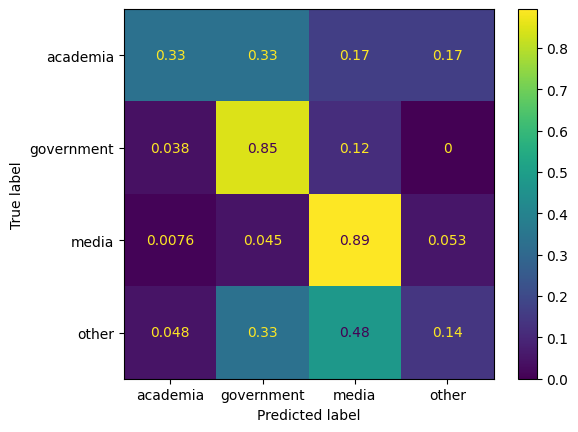

Confusion Matrix for NB tfidf:


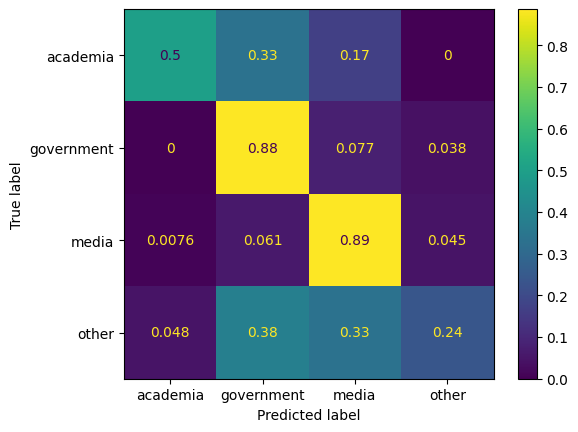

In [20]:
# Cross Fold Confusion Matrix for Train set
y_pred_count = cross_val_predict(nb_count_pipeline, X_train, y_train, cv=5)
y_pred_tfidf = cross_val_predict(nb_tfidf_pipeline, X_train, y_train, cv=5)

cm_count = confusion_matrix(y_train, y_pred_count, normalize='true')
cm_tfidf = confusion_matrix(y_train, y_pred_tfidf, normalize='true')

disp_count = ConfusionMatrixDisplay(confusion_matrix=cm_count, display_labels=['academia', 'government', 'media', 'other'])
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=['academia', 'government', 'media', 'other'])
print('Confusion Matrix for NB word frequencies:')
disp_count.plot()
plt.show()
print('Confusion Matrix for NB tfidf:')
disp_tfidf.plot()
plt.show()

In [21]:
print("Word-Frequencies Classification Report:")
print(metrics.classification_report(y_train, y_pred_count))
print()
print("TF-IDF Classification Report:")
print(metrics.classification_report(y_train, y_pred_tfidf))

Word-Frequencies Classification Report:
                precision    recall  f1-score   support

  ['academia']       0.40      0.33      0.36         6
['government']       0.59      0.85      0.70        26
     ['media']       0.89      0.89      0.89       132
     ['other']       0.27      0.14      0.19        21

      accuracy                           0.78       185
     macro avg       0.54      0.55      0.54       185
  weighted avg       0.77      0.78      0.77       185


TF-IDF Classification Report:
                precision    recall  f1-score   support

  ['academia']       0.60      0.50      0.55         6
['government']       0.56      0.88      0.69        26
     ['media']       0.92      0.89      0.90       132
     ['other']       0.42      0.24      0.30        21

      accuracy                           0.80       185
     macro avg       0.62      0.63      0.61       185
  weighted avg       0.80      0.80      0.79       185



Fit models to the feature set and evaluate performance

In [16]:
# Fit models with best hyperparamets and predict on test set
y_pred_count = nb_count_pipeline.predict(X_test)
y_pred_tfidf = nb_tfidf_pipeline.predict(X_test)

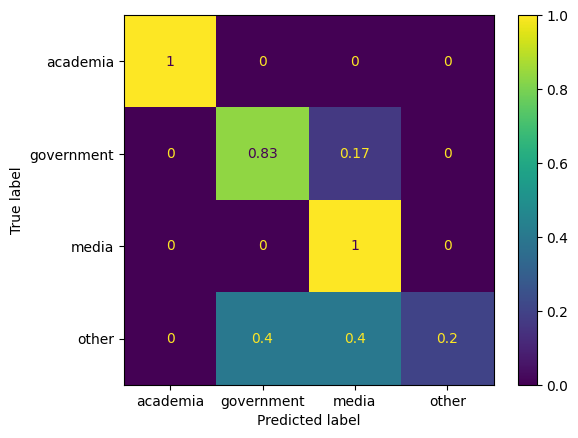

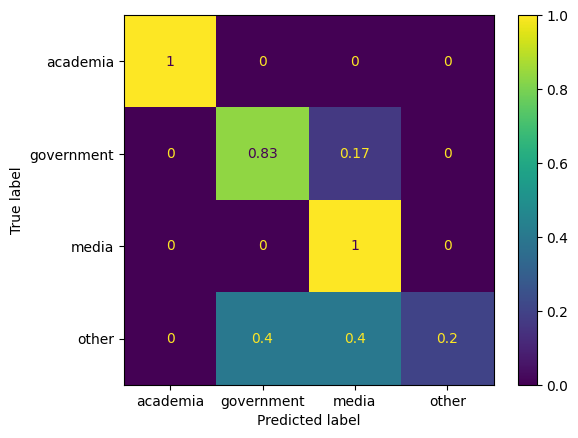

In [18]:
# Confusion Matrix
cm_count = confusion_matrix(y_test, y_pred_count, normalize='true')
cm_tfidf = confusion_matrix(y_test, y_pred_tfidf, normalize='true')

disp_count = ConfusionMatrixDisplay(confusion_matrix=cm_count, display_labels=['academia', 'government', 'media', 'other'])
disp_tfidf = ConfusionMatrixDisplay(confusion_matrix=cm_tfidf, display_labels=['academia', 'government', 'media', 'other'])

disp_count.plot()
plt.show()

disp_tfidf.plot()
plt.show()

In [19]:
# Print classification report
print("Word-Frequencies Classification Report:")
print(metrics.classification_report(y_test, y_pred_count))
print()

print("TF-IDF Classification Report:")
print(metrics.classification_report(y_test, y_pred_tfidf))
print()

Word-Frequencies Classification Report:
                precision    recall  f1-score   support

  ['academia']       1.00      1.00      1.00         2
['government']       0.71      0.83      0.77         6
     ['media']       0.92      1.00      0.96        34
     ['other']       1.00      0.20      0.33         5

      accuracy                           0.89        47
     macro avg       0.91      0.76      0.77        47
  weighted avg       0.90      0.89      0.87        47


TF-IDF Classification Report:
                precision    recall  f1-score   support

  ['academia']       1.00      1.00      1.00         2
['government']       0.71      0.83      0.77         6
     ['media']       0.92      1.00      0.96        34
     ['other']       1.00      0.20      0.33         5

      accuracy                           0.89        47
     macro avg       0.91      0.76      0.77        47
  weighted avg       0.90      0.89      0.87        47


